# Credit Card Fraud Detection Dataset -  Dimensionality Reduction and Classification

The main objective of this analysis is to apply dimensionality reduction techniques to a 
highly imbalanced credit card transaction dataset to uncover latent behavioral patterns 
that improve downstream fraud detection performance. 

Its focus is on dimensionality reduction, rather than clustering, with the goal of learning 
compact representations that preserve meaningful transaction structure while 
reducing noise and redundancy. 

The business value of the project is to improve the robustness of the model in the 
presence of class imbalances and reduce the computational complexity while 
enabling a more interpretable classification model which will lead to having a more 
insightful vision of the risk of each transaction.

## Loading the dataset

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("miadul/credit-card-fraud-detection-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Masters\.cache\kagglehub\datasets\miadul\credit-card-fraud-detection-dataset\versions\1


In [6]:
import pandas as pd
df = pd.read_csv((path +"\credit_card_fraud_10k.csv"))
df.head()


,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


# Exploratory Data Analysis

## Dataset Description

In [7]:
df.describe()

,transaction_id,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,175.949849,11.593300,0.097800,0.085700,61.798900,2.008900,43.468700,0.015100
std,2886.89568,175.392827,6.922708,0.297059,0.279935,21.487053,1.432559,14.979147,0.121957
min,1.00000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,18.000000,0.000000
25%,2500.75000,50.905000,6.000000,0.000000,0.000000,43.000000,1.000000,30.000000,0.000000
50%,5000.50000,122.095000,12.000000,0.000000,0.000000,62.000000,2.000000,44.000000,0.000000
75%,7500.25000,242.480000,18.000000,0.000000,0.000000,80.000000,3.000000,56.000000,0.000000
max,10000.00000,1471.040000,23.000000,1.000000,1.000000,99.000000,9.000000,69.000000,1.000000


## Classes representation

It is a very imbalanced dataset.

In [8]:
df.is_fraud.value_counts()

is_fraud
0    9849
1     151
Name: count, dtype: int64

## Distribution of each feature

The feature distributions reveal strong skewness, discrete behavioral patterns, and weak standalone predictors, reinforcing the need for dimensionality reduction to uncover latent transaction behaviors critical for effective fraud detection.

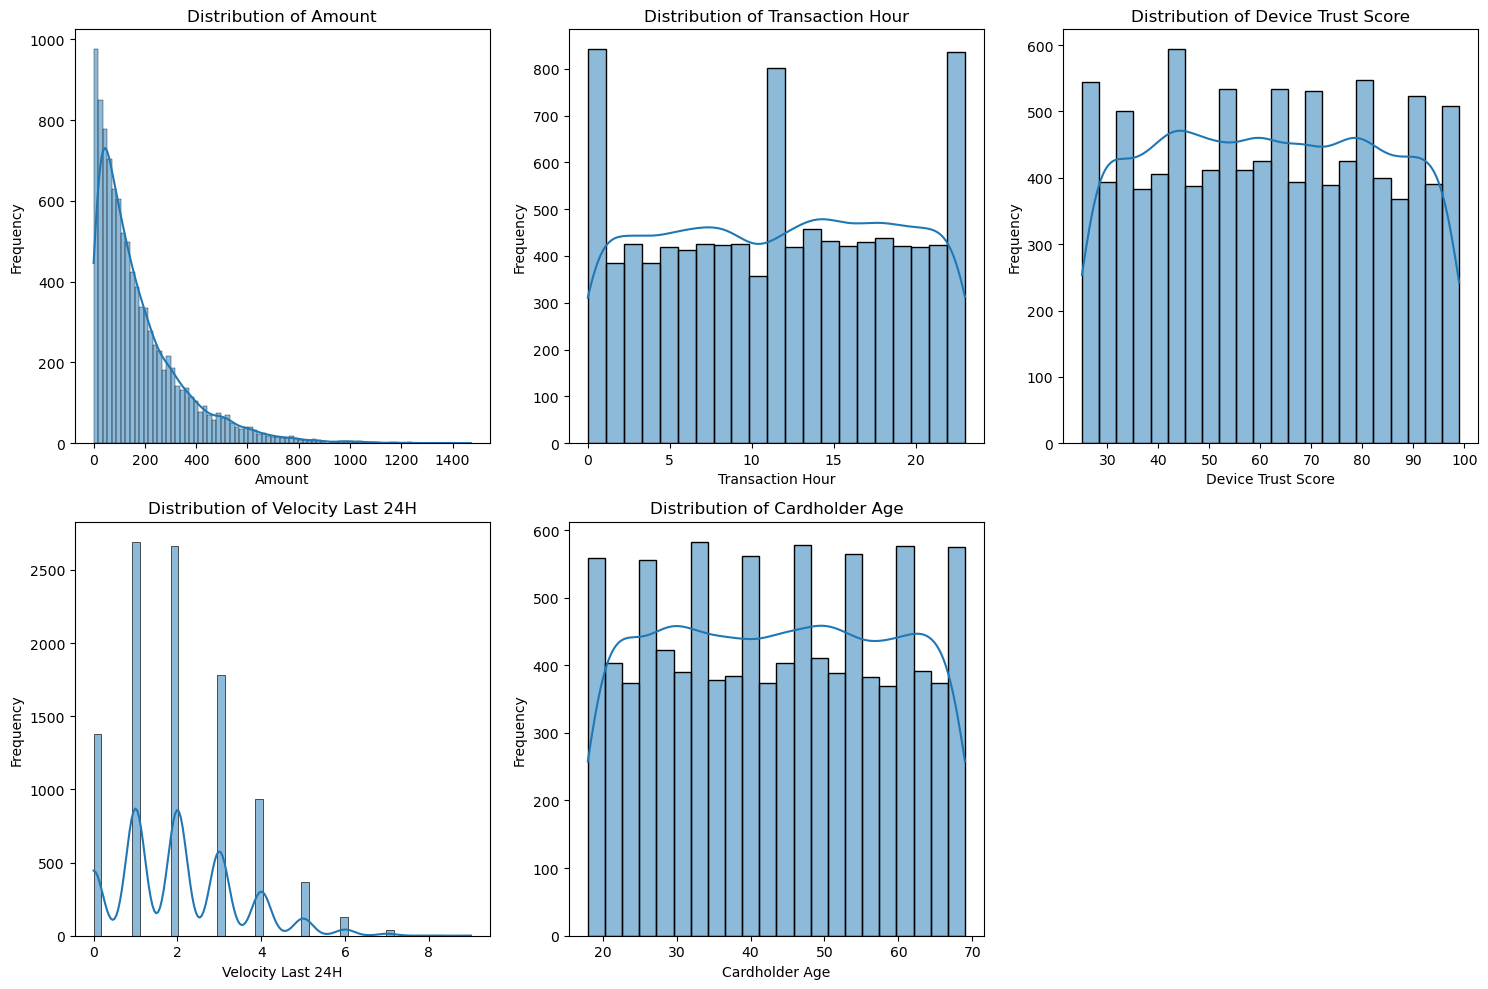

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get numerical columns (excluding 'transaction_id' and 'is_fraud' for distribution plots)
numerical_cols = ['amount', 'transaction_hour', 'device_trust_score', 'velocity_last_24h', 'cardholder_age']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


## Correlation Heatmap

The correlation analysis shows no dominant linear drivers of fraud, indicating that fraudulent behavior is governed by subtle, multivariate patterns.

Overall Observation

* Most feature pairs exhibit very low linear correlation (|ρ| ≈ 0.00–0.10).

* This indicates low redundancy and limited linear dependence across features.

* Implication: The dataset is well-suited for dimensionality reduction to capture latent structure rather than simple feature elimination.

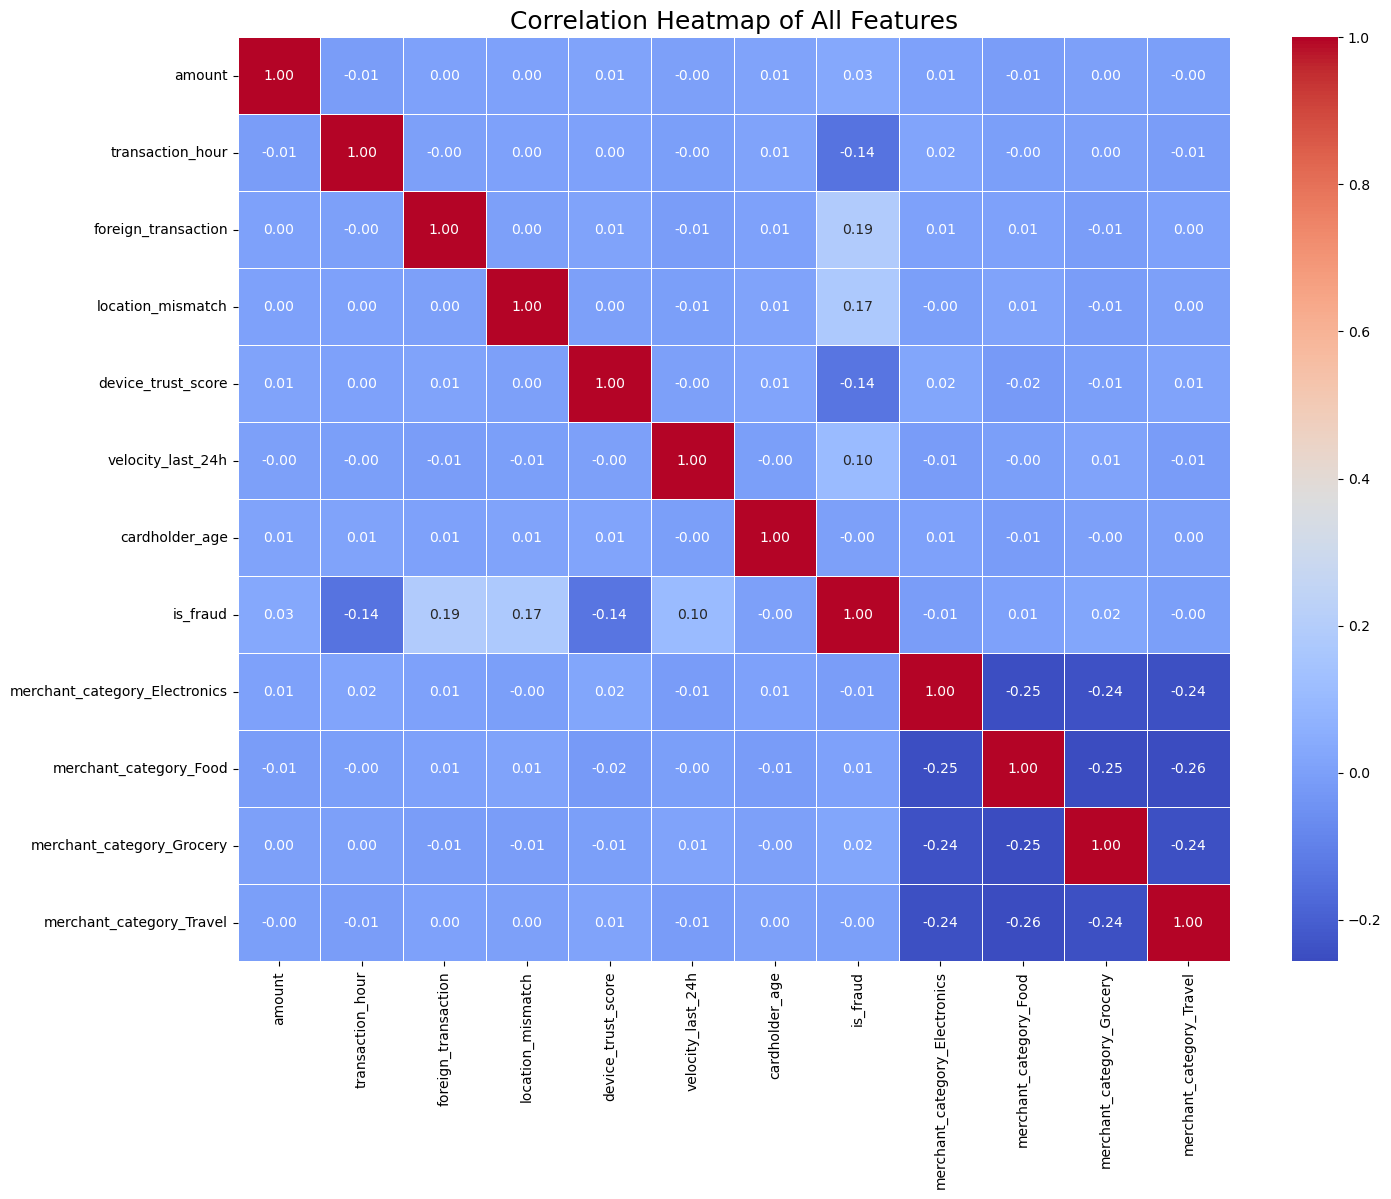


Correlation with 'is_fraud':
is_fraud                         1.000000
foreign_transaction              0.185597
location_mismatch                0.173009
velocity_last_24h                0.103413
amount                           0.028404
merchant_category_Grocery        0.019987
merchant_category_Food           0.006845
cardholder_age                  -0.000590
merchant_category_Travel        -0.002155
merchant_category_Electronics   -0.010481
device_trust_score              -0.137913
transaction_hour                -0.138665
Name: is_fraud, dtype: float64


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop 'transaction_id' as it's an identifier and not a feature for correlation
df_corr = df.drop('transaction_id', axis=1).copy()

# One-hot encode 'merchant_category' for correlation analysis
df_corr = pd.get_dummies(df_corr, columns=['merchant_category'], drop_first=True)

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of All Features', fontsize=18)
plt.show()

# Optionally, display correlations with 'is_fraud' specifically
print("\nCorrelation with 'is_fraud':")
print(correlation_matrix['is_fraud'].sort_values(ascending=False))

# Data Splitting

In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
y = df['is_fraud']
X = df.drop(['transaction_id', 'is_fraud'], axis=1)

# One-hot encode 'merchant_category' for features
X = pd.get_dummies(X, columns=['merchant_category'], drop_first=True)

# Split the data into training and testing sets
# Using stratify=y to maintain the proportion of fraud cases in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nDistribution of 'is_fraud' in y_train:")
print(y_train.value_counts(normalize=True))
print("\nDistribution of 'is_fraud' in y_test:")
print(y_test.value_counts(normalize=True))

X_train shape: (8000, 11)
X_test shape: (2000, 11)
y_train shape: (8000,)
y_test shape: (2000,)

Distribution of 'is_fraud' in y_train:
is_fraud
0    0.984875
1    0.015125
Name: proportion, dtype: float64

Distribution of 'is_fraud' in y_test:
is_fraud
0    0.985
1    0.015
Name: proportion, dtype: float64


# Pipeline creation

In [14]:
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

from scipy.stats import loguniform
log_clf = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    max_iter=1000,
    random_state=42

)

kmeans_clf = KMeans(n_clusters=2, random_state=42)


def get_pipeline(clf):
  pipeline = Pipeline(steps=[
      ("scaler", StandardScaler()),
      ("pca", PCA()),
      ("smote", SMOTE(random_state=42)),
      ("clf", clf)
  ])
  return pipeline

param_distributions = [
    # PCA lineal
    {
        "pca": [PCA(random_state=42)],
        "pca__n_components": [0.90, 0.95],
        "clf__C": loguniform(1e-2, 1e1),
        "clf__class_weight": [None, "balanced"]
    },
    # Kernel PCA
    {
        "pca": [KernelPCA(kernel="rbf", fit_inverse_transform=False)],
        "pca__n_components": [10, 15, 20],
        "pca__gamma": loguniform(1e-3, 1e-1),
        "clf__C": loguniform(1e-2, 1e1),
        "clf__class_weight": [None, "balanced"]
    }
]




# Training the Logistic Regression Model

In [ ]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Creating the pipeline for logistic regresion
log_pipeline = get_pipeline(log_clf)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=log_pipeline,
    param_distributions=param_distributions,
    n_iter=20,                 
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters found:")
print(random_search.best_params_)

print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")



Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'clf__C': np.float64(4.83595277646595), 'clf__class_weight': 'balanced', 'pca': KernelPCA(kernel='rbf'), 'pca__gamma': np.float64(0.028480262754225192), 'pca__n_components': 20}
Best CV ROC-AUC: 0.9945


c:\Users\Masters\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Masters\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Masters\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Masters\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~

# Testing the Logistic Regression Model

In [16]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print(f"ROC-AUC en test: {roc_auc:.4f}")

print(f"Classification Report: ")

print(classification_report(y_test, y_pred))


ROC-AUC en test: 0.9934
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1970
           1       0.31      0.93      0.47        30

    accuracy                           0.97      2000
   macro avg       0.66      0.95      0.73      2000
weighted avg       0.99      0.97      0.98      2000



# Training the K Means Model

In [ ]:
kmeans_pipeline = get_pipeline(kmeans_clf)
kmeans_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.95, random_state=42)),
                ('smote', SMOTE(random_state=42)),
                ('clf', KMeans(n_clusters=2, random_state=42))])

# Testing the K-Mean Model

In [ ]:
y_pred = kmeans_pipeline.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1970
           1       0.08      0.87      0.14        30

    accuracy                           0.85      2000
   macro avg       0.54      0.86      0.53      2000
weighted avg       0.98      0.85      0.90      2000

ROC-AUC: 0.8559221658206431


# Conclusion

This project examined whether unsupervised dimensionality reduction can improve 
fraud detection in a highly imbalanced credit card transaction dataset. Principal 
Component Analysis (PCA) and Kernel PCA were used as unsupervised feature learning 
methods, and their representations were evaluated using a downstream logistic 
regression classifier. Also, a K Means model was used for comparison. 

A RandomizedSearchCV approach was applied to compare linear PCA (90% and 95% 
explained variance) with Kernel PCA using an RBF kernel. Pipelines and stratified cross
validation were used to prevent data leakage and ensure a fair and efficient 
comparison. 

The results indicate that Kernel PCA consistently outperformed linear PCA, suggesting 
that fraudulent behavior is driven by non-linear patterns not captured by linear 
projections. The non-linear latent space learned by Kernel PCA led to improved 
classification performance. 

Logistic regression achieved 97% accuracy and an ROC-AUC of 0.993, indicating strong 
discrimination between fraudulent and legitimate transactions. Importantly, the model 
reached a fraud recall of 0.93, showing effective detection of most fraudulent cases. 
Although fraud precision was moderate (0.31), this trade-off is expected and 
acceptable in fraud detection, where recall is a higher priority. 

Overall, the findings show that unsupervised dimensionality reduction is an effective 
tool for detection of fraud in imbalanced settings. By learning compact and non-linear 
representations, Kernel PCA improves performance and robustness without relying on 
complex supervised models. 

In conclusion, I recommend combining Kernel PCA with a simple and interpretable 
classifier that provides a strong and scalable baseline for fraud detection, balancing 
performance, and interpretability for practical deployment. 
For next research, I suggest implementing a 1D CNN or SVM model that could get a 
better performance for this type of data.